# KerasのRNN(LSTM)でFizzBuzz問題を解いてみた

PythonのディープラーニングライブラリKerasで、再帰型ニューラルネットワーク（RNN）のLSTM（長短期記憶ユニット）を使って、FizzBuzz問題を解いてみました。

## FizzBuzz問題とは

**問題**

1以上、100以下の整数値を出力するプログラムを書け。ただし；

- 3の倍数のときは、数の代わりに「Fizz」と出力せよ
- 5の倍数のときは、数の代わりに「Buzz」と出力せよ
- 3と5の公倍数のときは、数の代わりに「FizzBuzz」と出力せよ

**公式解答**

普通は、for文とif文を使って解きます。

```python
for i in range(1, 101):
    if i % 15 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(str(i))
```

```
1
2
Fizz
...(中略)...
98
Fizz
Buzz
```

## 先人達

あえて、機械学習やディープラーニングの手法でFizzBuzz問題を解いた先人達です。

- [サポートベクターマシン（のライブラリLIVSVM）を使ってpythonでFizzBuzzを書いてみた。](https://qiita.com/cof/items/e02ada0adb1106635ac9)
- [Kerasでfizzbuzz問題を解いてみる](https://qiita.com/cvusk/items/07659830c41b2c3ff02b)
- [PythonとK-meansを使ったFizzbuzz](https://qiita.com/Polaris1080/items/3fdabed9567effb69781)
- [FizzBuzz Zero ―― 人類の知識なしでFizzBuzzをマスターする](https://qiita.com/ymg_aq/items/d276357823f5b2ce46c5)

LSTMで解いた人は、少なくともQiitaにはいないようだったので、解いてみました。

なお、LSTMについては、[この記事](https://qiita.com/KojiOhki/items/89cd7b69a8a6239d67ca#lstm%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF)が詳しいです。

## 問題を解く

### ライブラリのインポート

In [1]:
from os import mkdir
from os.path import exists
from sys import exc_info
from itertools import cycle, islice
from numpy import array, eye, shape, sum, unique
import keras.optimizers as opt
import keras.backend as K
import keras.callbacks as clb
import keras.models as mdl
import keras.layers as lyr
import keras.losses as lss
import matplotlib.pyplot as plt

Using TensorFlow backend.


### データの作成

FizzBuzzの取りうる値は4種類（数字：0、Fizz：1、Buzz：2、FizzBuzz：3）です。そこに着目して、データを正規化しちゃいます。そうすると、15個のデータで1サイクルとなるので、これを繰り返してデータを生成します。データ量は何度か試行の末、3015に落ち着きました。

In [2]:
unit = [0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 3]
raw_data = array([i for i in islice(cycle(unit), 0, 3015)])
print(raw_data[0:30])
print(type(raw_data))

[0 0 1 0 2 1 0 0 1 2 0 1 0 0 3 0 0 1 0 2 1 0 0 1 2 0 1 0 0 3]
<class 'numpy.ndarray'>


FizzBuzzは**分類問題**と考えられるので、教師データ（正解データ、ラベル）をone-hot表現で与えます。以下はその下準備です。

In [3]:
num_of_class = len(unique(unit))
onehot_data = eye(num_of_class)[raw_data]
print(onehot_data[0:5])
print(type(onehot_data))

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
<class 'numpy.ndarray'>


LSTMに食わせられるように、インプットとターゲットを整えます。`num_steps`は、LSTMで何ステップ分まで過去の出力を考慮に入れて予測するかを決める変数になります。15個のデータで1サイクルなので、理論上、`num_steps`は15で良いはずです。

以下のイメージです。

- -14〜0をインプットとし、1をターゲットにする
- -13〜1をインプットとし、2をターゲットにする
- -12〜2をインプットとし、3をターゲットにする
- ...


In [4]:
t_inputs, t_targets = [], []
num_steps = len(unit) #15

for i in range(len(raw_data) - num_steps):
    t_inputs.append(raw_data[i : i + num_steps])
    t_targets.append(onehot_data[i + num_steps])

print(t_inputs[0:2])
print(t_targets[0:2])

[array([0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 3]), array([0, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 3, 0])]
[array([1., 0., 0., 0.]), array([1., 0., 0., 0.])]


LSTMが食ってくれるように、形状を整えます。

In [5]:
inputs = array(t_inputs).reshape(len(t_inputs), num_steps, 1)
targets = array(t_targets)

print(shape(inputs))
print(shape(targets))

(3000, 15, 1)
(3000, 4)


### モデルの作成

モデルクラスを作成します。要点は以下の3行です。

```python
        self.__model.add(lyr.LSTM(Model.units))
#        for i in (range(Model.number_of_layer)):
#            self.__model.add(lyr.Dense(Model.units, activation=Model.activation))
        self.__model.add(lyr.Dense(targets.shape[1], activation=K.softmax))
        self.__model.compile(loss=lss.categorical_crossentropy, optimizer=Model.optimizer)
```

入力層でLSTMネットワークに通して、出力層でソフトマックス関数を使って4つに分類します。シンプルなネットワークですね。LSTMの中身は結構複雑なんですが、Kerasさんがカプセル化してくれているので、とてもシンプルに見えます。

なお、分類問題としたので、損失は交差エントロピーで評価します。

In [6]:
class Model:
    # モデル保存先
    modeldir = './data'
    modelfile = './data/Model.h5'

    # モデルに関するパラメータ
#    number_of_layer = 0
    units = 32
    
    optimizer = opt.Adam()
#    activation = K.identity
    
    # 訓練に関するパラメータ
    batch_size = 15
    epochs = 10
    
    callbacks = []

#    min_delta = 0.01
#    patience = 7
#    early_stopping = clb.EarlyStopping(monitor='val_loss'
#                                       , min_delta=min_delta
#                                       , patience=patience
#                                       , mode='auto')
#    calllbacks.append(early_stopping)

#    base_lr = 1e-3
#    lr_decay_rate = 1 / 3
#    lr_steps = 4
#    lr_calc = lambda ep: float(
#        base_lr * lr_decay_rate ** (ep * lr_steps // epochs))
#    learning_rate_scheduler = clb.LearningRateScheduler(lr_calc)
#    callbacks.append(learning_rate_scheduler)

    factor = 0.5
    verbose = 1
    reduce_lr_on_plateau = clb.ReduceLROnPlateau(factor=factor,
                                                 verbose=verbose)
    callbacks.append(reduce_lr_on_plateau)

    validation_split = 0.1
    
    # モデルの初期化
    def __init__(self, recycle=True):
        if recycle:
            if exists(Model.modelfile):
                try:
                    print('訓練済みモデルを読み込みます。')
                    self.__model = mdl.load_model(Model.modelfile)
                    self.__istrained = True
                    print('訓練済みモデルを読み込みました。')
                    return None
                except:
                    print('訓練済みモデルの読み込み中にエラーが発生しました。')
                    print('Unexpected error:', exc_info()[0])
                    raise
            else:
                print('訓練済みモデルが存在しません。')
                
        print('空のモデルを作成します。')
        self.__model = mdl.Sequential()
        self.__istrained = False
        print('空のモデルを作成しました。訓練を行ってください。')
            
    # 訓練
    def train(self, inputs, targets):
        if self.__istrained:
            raise RuntimeError('このモデルは既に訓練済みです。')
        
        print('訓練を行うので、お待ちください。')
#        print('学習が頭打ちになった場合、途中で訓練を打ち切ります。')

        # モデルの実装
        self.__model.add(lyr.LSTM(Model.units))
#        for i in (range(Model.number_of_layer)):
#            self.__model.add(lyr.Dense(Model.units, activation=Model.activation))
        self.__model.add(lyr.Dense(targets.shape[1], activation=K.softmax))
        self.__model.compile(loss=lss.categorical_crossentropy, optimizer=Model.optimizer)

        # 訓練実施
        hist = self.__model.fit(inputs, targets,
                                batch_size=Model.batch_size
                                , epochs=Model.epochs
                                , callbacks=Model.callbacks
                                , validation_split=Model.validation_split
                               )
        self.__istrained = True
        
        # 訓練状況の可視化
        loss = hist.history['loss']
        val_loss = hist.history['val_loss']
        
        plt.figure()
        plt.plot(range(1, len(loss) + 1),
                 loss, marker='.', label='訓練データ')
        plt.plot(range(1, len(val_loss) + 1),
                 val_loss, marker='.', label='テストデータ')
        plt.legend(loc='best', fontsize=10)
        plt.grid()
        plt.xlabel('エポック')
        plt.ylabel('損失')
        plt.yscale('log')
        plt.grid(which='major',color='black',linestyle='-')
        plt.grid(which='minor',color='black',linestyle='-')
        plt.show()
        
        # モデルの保存
        if not exists(Model.modeldir):
            try:
                mkdir(Model.modeldir)
            except:
                print('モデル保存フォルダの作成中にエラーが発生しました。')
                print('Unexpected error:', exc_info()[0])
                raise
        try:
            self.__model.save(Model.modelfile)
        except:
            print('モデルの保存中にエラーが発生しました。')
            print('Unexpected error:', exc_info()[0])
            raise
    
    # 予測
    def predict(self, inputs):
        if self.__istrained:
            return self.__model.predict(inputs)
        else:
            raise RuntimeError('モデルが訓練されていません。先に訓練を行ってください。')

### モデルを使うクラスの作成

モデルを使って問題を解くクラスを作成します。初期入力値として、-14〜0に相当するパターンを隠し持っておきます。

- そいつをインプットとして予測を実施
- 予測結果に応じたFizzBuzz表現を、解答末尾に追加
- インプットの先頭を削除して、末尾に予測結果を追加し、新たなインプットとする

以後、同じことの繰り返しです。

In [7]:
class FizzBuzz:
    def __init__(self, model):
        self.__model = model
    
    def fizzbuzz(self, n):
        unit = [0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 3]
        i = 1
        answer = []
        for i in range(i, n + 1):
            t_inputs = array ([unit])
            inputs = t_inputs.reshape(len(t_inputs), len(unit), 1)
            prd = self.__model.predict(inputs) [0].argmax()
            if prd == 0:
                answer.append(str(i))
            elif prd == 1:
                answer.append('Fizz')
            elif prd == 2:
                answer.append('Buzz')
            elif prd == 3:
                answer.append('FizzBuzz')
            else:
                answer.append(str(i))
            unit.pop(0)
            unit.append(prd)
        return answer

正答率をチェックするクラスも作成しておきます。

In [8]:
class FizzBuzzChecker:
    def check(self, answer):
        collect_answer = ["FizzBuzz" if i % 15 == 0
                          else "Fizz" if i % 3 == 0
                          else "Buzz" if i % 5 == 0
                          else str(i)
                          for i in range(1, len(answer) + 1)]
        score = sum(array(answer) == array(collect_answer)) / len(answer)
        return score

### 実行

準備は整ったので、いざ実行に移します。

空のモデルを作成します。
空のモデルを作成しました。訓練を行ってください。
訓練を行うので、お待ちください。
Train on 2700 samples, validate on 300 samples
Epoch 1/10
2700/2700 [==============================] - 3s 1ms/step - loss: 1.1208 - val_loss: 1.0676
Epoch 2/10
2700/2700 [==============================] - 3s 927us/step - loss: 1.0046 - val_loss: 0.8683
Epoch 3/10
2700/2700 [==============================] - 2s 902us/step - loss: 0.7202 - val_loss: 0.5360
Epoch 4/10
2700/2700 [==============================] - 2s 846us/step - loss: 0.3594 - val_loss: 0.1428
Epoch 5/10
2700/2700 [==============================] - 2s 867us/step - loss: 0.0783 - val_loss: 0.0316
Epoch 6/10
2700/2700 [==============================] - 2s 887us/step - loss: 0.0206 - val_loss: 0.0137
Epoch 7/10
2700/2700 [==============================] - 2s 877us/step - loss: 0.0107 - val_loss: 0.0081
Epoch 8/10
2700/2700 [==============================] - 2s 888us/step - loss: 0.0067 - val_loss: 0.0056
Epoch 9/10
2700/2700 [==============================] - 2s 866us/ste

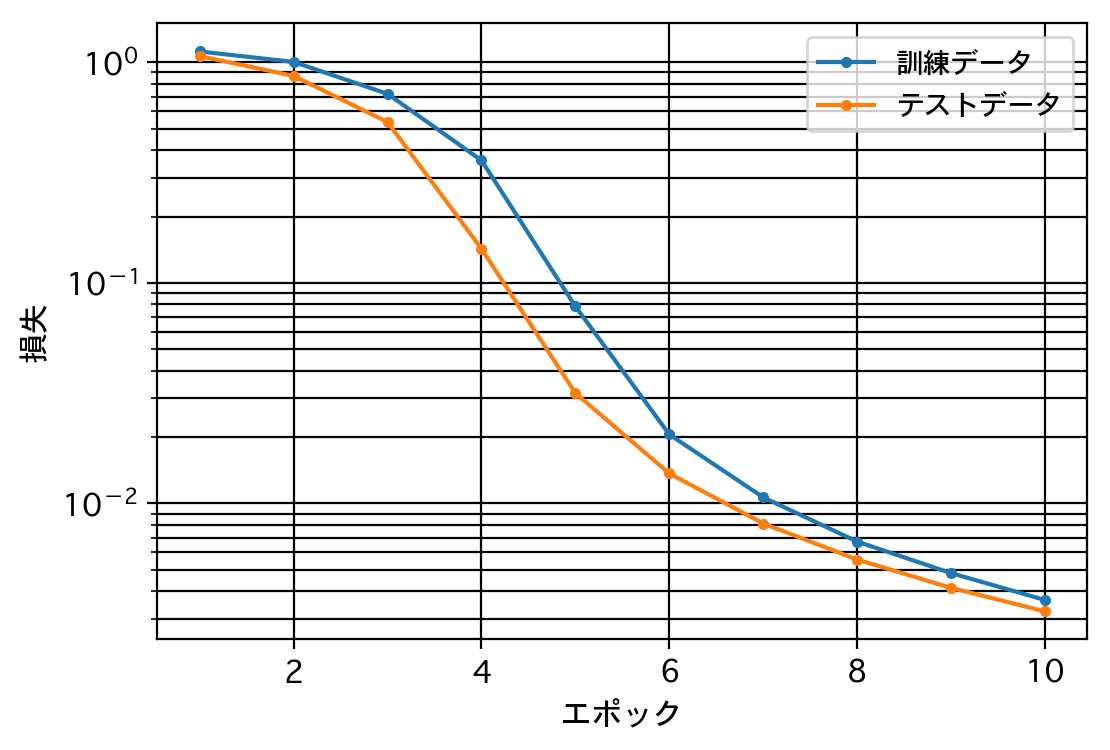

['1', '2', 'Fizz', '4', 'Buzz', 'Fizz', '7', '8', 'Fizz', 'Buzz', '11', 'Fizz', '13', '14', 'FizzBuzz', '16', '17', 'Fizz', '19', 'Buzz', 'Fizz', '22', '23', 'Fizz', 'Buzz', '26', 'Fizz', '28', '29', 'FizzBuzz', '31', '32', 'Fizz', '34', 'Buzz', 'Fizz', '37', '38', 'Fizz', 'Buzz', '41', 'Fizz', '43', '44', 'FizzBuzz', '46', '47', 'Fizz', '49', 'Buzz', 'Fizz', '52', '53', 'Fizz', 'Buzz', '56', 'Fizz', '58', '59', 'FizzBuzz', '61', '62', 'Fizz', '64', 'Buzz', 'Fizz', '67', '68', 'Fizz', 'Buzz', '71', 'Fizz', '73', '74', 'FizzBuzz', '76', '77', 'Fizz', '79', 'Buzz', 'Fizz', '82', '83', 'Fizz', 'Buzz', '86', 'Fizz', '88', '89', 'FizzBuzz', '91', '92', 'Fizz', '94', 'Buzz', 'Fizz', '97', '98', 'Fizz', 'Buzz']
1~100までの正答率：1.0
1~10000までの正答率：1.0


In [9]:
m = Model(recycle=False)
m.train(inputs, targets)

fb = FizzBuzz(m)

ans = fb.fizzbuzz(100)
print(ans)

chkr = FizzBuzzChecker()
print('1~100までの正答率：' + str(chkr.check(ans)))

ans2 = fb.fizzbuzz(10000)
print('1~10000までの正答率：' + str(chkr.check(ans2)))

パーフェクト！

外挿（1〜10000）にも成功しているのがいい感じですね。

## 考察

とはいえ、FizzBuzzのように明確な周期をもったデータに対してLSTMを適用すれば、そりゃ100点も取れるし、外挿にも成功しますよね。

そうではなくて、明確な周期をもたないと思われるデータに関する問題、例えば、バイナリーオプション——過去一定期間のドル円相場を元に次時点の上昇／下落を予測するという問題——に対して、LSTMを適用すると何が起きるのでしょう。うまくいくのでしょうか。過去の相場だけが決定要因ではないだろうから、そう簡単にはいかない気がしますけどね。ごく短期間にしぼればうまくいくのかな？

でもま、FizzBuzz大好きっ子としては、Yet Anotherな解き方を発見できたので、それだけで大満足です。

## 参考サイト

- [LSTM で正弦波を予測する](https://intheweb.io/lstm-dezheng-xian-bo-woyu-ce-suru/)
- [深層学習ライブラリKerasでRNNを使ってsin波予測](https://qiita.com/yukiB/items/5d5b202af86e3c587843)
- [KerasでRNN(LSTM)を試してみる](https://qiita.com/sasayabaku/items/b7872a3b8acc7d6261bf)
- [整数値のベクトルをone hot表現に変換](https://qiita.com/JeJeNeNo/items/8a7c1781f6a6ad522adf)
- [出力層で使うソフトマックス関数](https://www.hellocybernetics.tech/entry/2016/11/30/012350)
- [配列の最大要素のインデックスを返すNumPyのargmax関数の使い方](https://deepage.net/features/numpy-argmax.html)
- [ndarrayにおける演算子](https://www.python-izm.com/data_analysis/numerical/numpy/ndarray_operators/#i-2)
- [Rosetta Code/FizzBuzz/Python: List Comprehension (Python 3)](https://rosettacode.org/wiki/FizzBuzz#Python:_List_Comprehension_.28Python_3.29)
- [NumPy配列ndarrayの条件を満たす要素数をカウント](https://note.nkmk.me/python-numpy-count/)
